# Entendimiento del negocio y de los datos

Durante el primer apartado, se entiende que Finkarcargo es una empresa que ofrece soluciones financieras ágiles, rápidas y asequibles para importadores colombianos y que sus productos están dirigidos a empresas legalmente constituidas hace más de 2 años que realizan importaciones anuales por más de 20.000 dólares. Teniendo esto en cuenta, se detectó la necesidad de predecir el comportamiento de las importaciones en el país.

Por este motivo, se explora la base de datos de importaciones que provee la DIAN, donde se puede extraer información acerca del número de importaciones por día de una partida arancelaria específica (productos de importación). asimismo, se pueden obtener datos relacionados con el valor de dichas importaciones.

Posteriormente, en la búsqueda de un producto mínimo viable, se decide tomar el número de importaciones de una partida arancelaria cada 15 días durante dos años y medio como insumo para determinar un modelo que se ajuste y pueda predecir con la mayor precisión posible. Se seleccionó la subpartida 87 porque cuenta con el mayor número de importaciones en ese periodo de tiempo.

# Conexión con la base de datos

In [297]:
import os
import pandas as pd
# from pandas.io import sql as psql
import snowflake.connector
import matplotlib.pyplot as plt
import seaborn as sns

In [318]:
DF = pd.DataFrame
ColName = str
url = 'pm09030.east-us-2.azure.snowflakecomputing.com'
class Snowflake:
    def __init__(self, database='IMPORTACIONES', db_schema='PUBLIC') -> None:
        self.user = 'proyect4'
        self.password = 'Proyecto4*'
        self.account = 'zq59521.east-us-2.azure'
        self.warehouse = 'COMPUTE_WH'
        self.role = 'ACCOUNTADMIN'
        engine = snowflake.connector.connect(
            account=self.account,
            user=self.user,
            password=self.password,
            database=database,
            schema=db_schema,
            warehouse=self.warehouse,
            role=self.role,
        )
        try:
            self.connection = engine
        except Exception as err:
            print("I am unable to connect to the database, {}".format(err))
            raise err

 

    def read_sql(self, sql: str, params=None) -> DF:
        if params is None:
            params = {}
        cs = self.connection.cursor()
        try:
            cs.execute(sql.format(**params))
            self.data = cs.fetch_pandas_all()
        finally:
            cs.close()
        return self.data
    def execute_sp_function(self, function_name, params=[]):
        connection = self.connection
        try:
            cursor = connection.cursor()
            cursor.execute(function_name, params)
            cursor.close()
            connection.commit()
            connection.close()
        except:
            connection.close()
            raise
    def execute_statement(self, sql_statement):
        """
        Executes non result returning statement
        :param sql_statement: sql to execute
        :return: void
        """
        connection = self.connection
        try:
            with connection.cursor() as cursor:
                cursor.execute(sql_statement)
        except Exception as e:
            connection.close()
            raise Exception(str(e))
    def set_session(self, tag):
        """
        Set the query tag in the current session
        """
        query_tag = f'ALTER SESSION SET QUERY_TAG = "{tag}"'
        self.execute_statement(query_tag)
    def insert_dataframe_bulk(self, df_to_insert, dest_table, mode, db_schema, flag=False):
        """
        function to save dataframes to tables using snowflake copy clause with parquet files
        this is a slightly modified version of snowflake.connector.pandas with the to_parquet date truncating issue solved
        :param df_to_insert: dataframe to insert
        :param dest_table: name of the table
        :param mode: append,fail or replace
        :param db_schema: schema of the destination table
        :return: None
        """
        if len(df_to_insert) == 0:
            return
        connection = self.connection
        compression = 'gzip'
        compression_map = {
            'gzip': 'auto',
            'snappy': 'snappy'
        }
        # on_error = 'abort_statement'
        stage_name = dest_table.upper()
        path = f'/tmp/{dest_table}.parquet.{compression}'
        if mode == 'replace':
            if flag:
                self.execute_statement(
                    f'drop table if exists {db_schema}.{stage_name}')
                self.execute_statement(pd.io.sql.get_schema(
                    df_to_insert, stage_name).replace('"', ''))
            else:
                """
                ALERT: 2022-06-14
                This function is deprecated because pandas.DataFrame.to_sql use a sqlAlchemy connection
                Always set the flag argument True
                """
                df_to_insert.head(0).to_sql(dest_table.lower(), con=self.connection, index=False, schema=db_schema,
                                            if_exists=mode)
        with connection.cursor() as cursor:
            try:
                # create stage
                try:
                    create_stage_sql = (
                        'create stage {db_schema}.{stage_name}').format(stage_name=stage_name, db_schema=db_schema)
                    cursor.execute(create_stage_sql)
                    connection.commit()
                except Exception as pe:
                    if pe.msg.endswith('already exists.'):
                        pass
                # saves parquet locally
                # using fastparquet because in auto and pyarrow engines datetimes are processed wrong
                # when using auto (default) engine, use these parameters to get the right datetimes in tables:
                # allow_truncated_timestamps=True, use_deprecated_int96_timestamps=True
                df_to_insert.to_parquet(path, engine='auto',  compression=compression, index=False,
                                        allow_truncated_timestamps=True, use_deprecated_int96_timestamps=True)
                # takes local parquet to snowflake stage area .4 parallel processes to load (default)
                upload_sql = ('PUT file://{path} @%{stage_name} PARALLEL={parallel}').format(
                    path=path,
                    stage_name=stage_name,
                    parallel=4
                )
                cursor.execute(upload_sql)
                connection.commit()
                # copy from stage to table
                copy_into_sql = 'COPY INTO {stage_name} MATCH_BY_COLUMN_NAME=CASE_INSENSITIVE ' \
                    'PURGE=TRUE FILE_FORMAT=(TYPE=PARQUET COMPRESSION={compression})'.format(
                        stage_name=stage_name,
                        compression=compression_map[compression])
                cursor.execute(copy_into_sql, _is_internal=True)
                connection.commit()
                os.remove(path)
                #connection.close()
            except Exception as e:
                connection.close()
                raise Exception(e)

In [319]:
db_obj = Snowflake()

snowflake.connector.connection INFO  Snowflake Connector for Python Version: 3.2.1, Python Version: 3.11.4, Platform: Windows-10-10.0.22621-SP0
snowflake.connector.connection INFO  This connection is in OCSP Fail Open Mode. TLS Certificates would be checked for validity and revocation status. Any other Certificate Revocation related exceptions or OCSP Responder failures would be disregarded in favor of connectivity.


## Carga y preparación de los datos

In [464]:
df = db_obj.read_sql("SELECT FECHA_PRESENTACION, count(*) as NUM FROM PUBLIC.IMPORTS WHERE LEFT(SUBPARTIDA_ARANCELARIA,2)='87' GROUP BY FECHA_PRESENTACION")

snowflake.connector.cursor INFO  query: [SELECT FECHA_PRESENTACION, count(*) as NUM FROM PUBLIC.IMPORTS WHERE LEFT(SUBPAR...]
snowflake.connector.cursor INFO  query execution done
snowflake.connector.cursor INFO  Number of results in first chunk: 866


In [465]:
df['FECHA_PRESENTACION'] = pd.to_datetime(df['FECHA_PRESENTACION'], format='%Y%m%d')
df = df.sort_values(by='FECHA_PRESENTACION', ascending=True).set_index("FECHA_PRESENTACION")

In [466]:
df

,NUM
FECHA_PRESENTACION,
2021-01-02,32
2021-01-04,462
2021-01-05,623
2021-01-06,646
2021-01-07,933
...,...
2023-06-26,876
2023-06-27,1213
2023-06-28,846


In [467]:
df.shape

(866, 1)

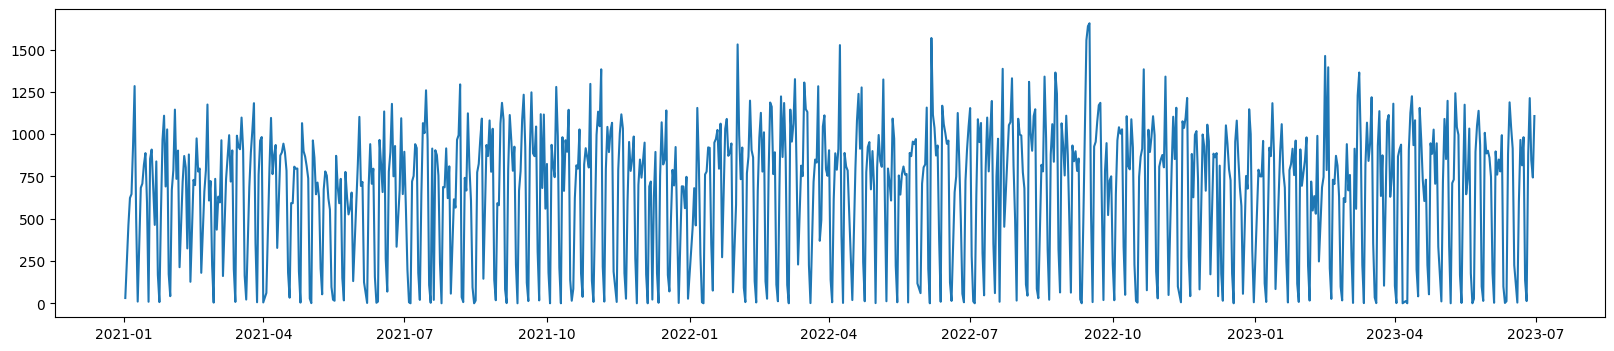

In [468]:
plt.figure(figsize=(20,4))
#df.plot.line(x='FECHA_PRESENTACION',y='NUM',figsize=(20,6))
plt.plot(df)
# plt.ylim(0,100000)
plt.show()

In [469]:
df = df.resample('15D').sum()

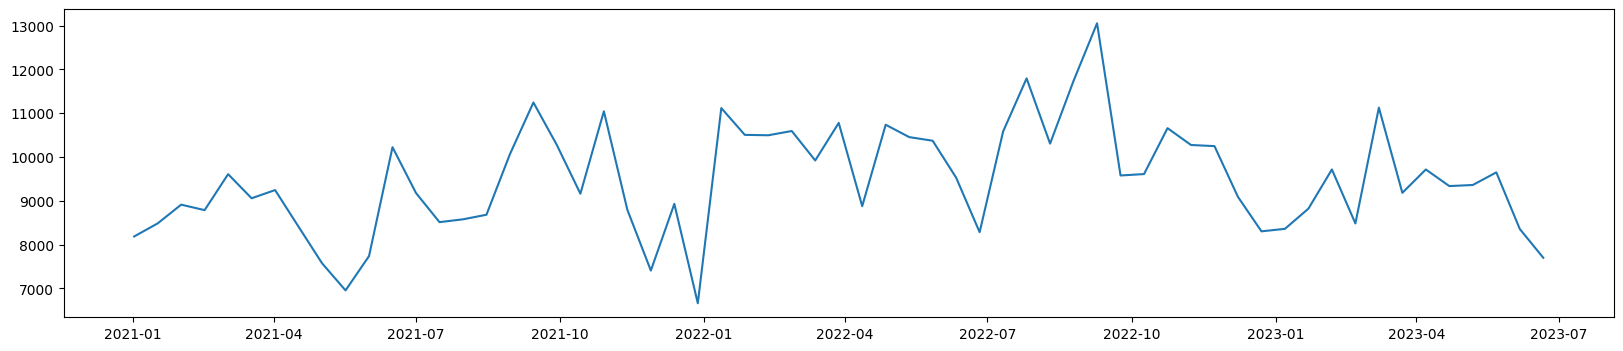

In [470]:
plt.figure(figsize=(20,4))
plt.plot(df)
plt.show()

# Modelado y evaluación

In [471]:
# Tratamiento de datos y graficos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# Statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

#Suavizacion exponencial
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing


from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax

#mecanismos de ajuste
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax

# Metricas
from sklearn.metrics import mean_absolute_percentage_error

# advertencias
import warnings

In [472]:
df = df.asfreq('15D')
#df['NUM'] = df['NUM'].fillna(0)
df = df['NUM']
type(df)

pandas.core.series.Series

In [473]:
df

FECHA_PRESENTACION
2021-01-02    8187
2021-01-17    8485
2021-02-01    8913
2021-02-16    8788
2021-03-03    9609
              ... 
2023-04-22    9337
2023-05-07    9362
2023-05-22    9650
2023-06-06    8358
2023-06-21    7701
Freq: 15D, Name: NUM, Length: 61, dtype: int64

## Suavización exponencial simple

In [474]:
def exponential_smoothing(series,alpha):
    result = [series[0]] # first value is same as series
    for n in range(1,len(series)):
        result.append(alpha*series[n]+(1-alpha)*result[n-1])
    return result

In [475]:
def plot_exponential_smoothing(series, alphas):
   plt.figure(figsize=(10,5))
   plt.plot(series.values, 'c', label = "Actual")
   for alpha in alphas:
        plt.plot(exponential_smoothing(series,alpha), label="Alpha {}".format(alpha))
   plt.legend(loc='best')
   plt.axis('tight')
   plt.title("Exponential Smoothing")
   plt.grid(True);

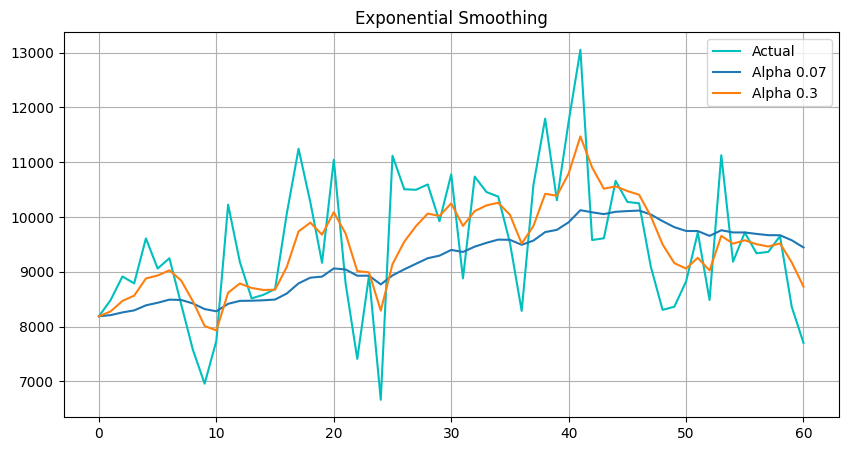

In [476]:
plot_exponential_smoothing(df,[0.07,0.3])

In [477]:
modeloSuavizacionSimple= SimpleExpSmoothing(df).fit(smoothing_level=0.07)
ajusteExponencialSImple=modeloSuavizacionSimple.fittedvalues
pronosticos= modeloSuavizacionSimple.forecast(100)

C:\Users\migav\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\util\_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


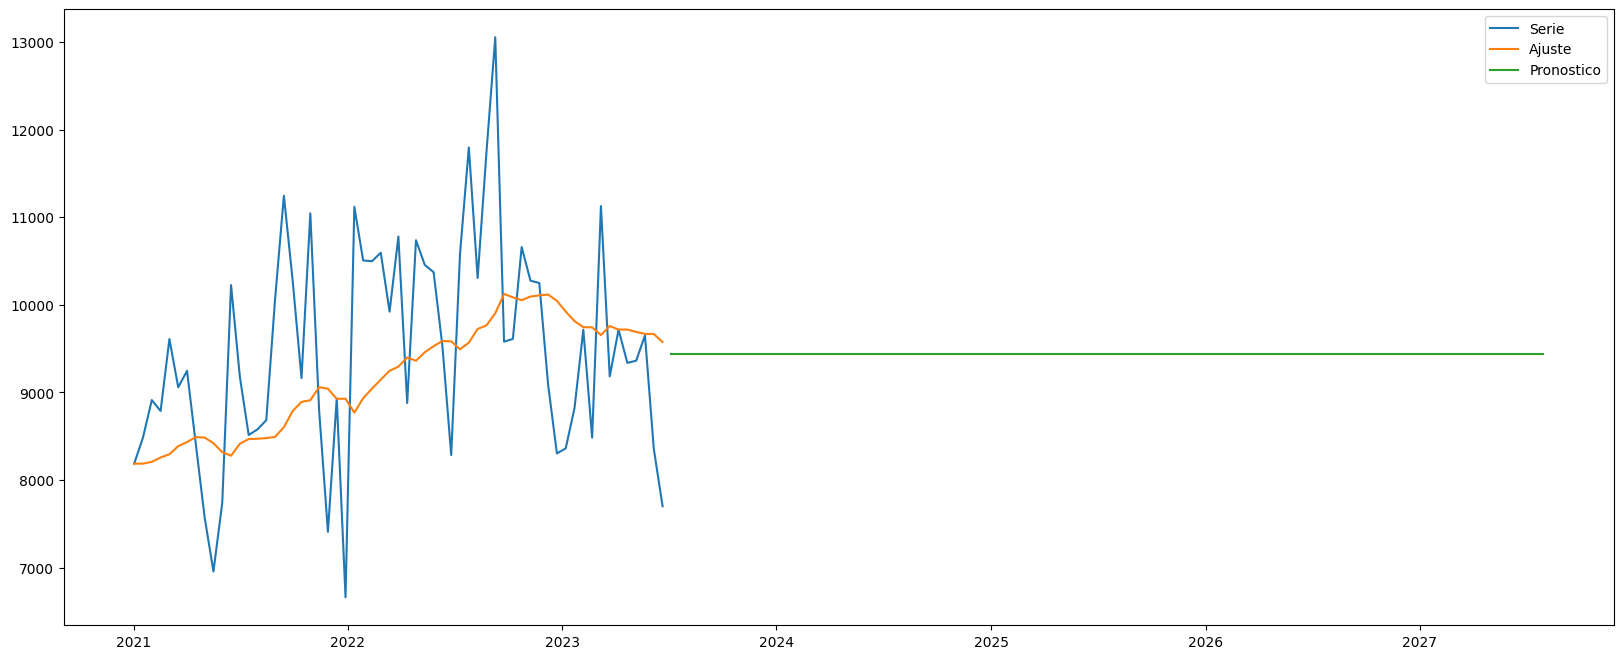

In [478]:
plt.figure(figsize=(20,8))
plt.plot(df,label='Serie')
plt.plot(ajusteExponencialSImple,label='Ajuste')
plt.plot(pronosticos,label='Pronostico')
plt.legend()
plt.show()

In [479]:
pronosticos

2023-07-06    9443.66625
2023-07-21    9443.66625
2023-08-05    9443.66625
2023-08-20    9443.66625
2023-09-04    9443.66625
                 ...    
2027-05-31    9443.66625
2027-06-15    9443.66625
2027-06-30    9443.66625
2027-07-15    9443.66625
2027-07-30    9443.66625
Freq: 15D, Length: 100, dtype: float64

### Evaluación suavización exponencial simple

In [480]:
resultado = exponential_smoothing(df, 0.05)
mean_absolute_percentage_error(df, resultado)

0.10041220456508655

## Modelo ARIMAX

In [481]:
fin_ajuste = "2023-03-01"
print(f"Fechas ajuste : {df.index.min()} --- {df.loc[:fin_ajuste].index.max()} (n = {len(df.loc[:fin_ajuste])})")
print(f"Fechas de Validacion : {df.loc[fin_ajuste:].index.min()} --- {df.loc[:].index.max()} (n = {len(df.loc[fin_ajuste:])})")

Fechas ajuste : 2021-01-02 00:00:00 --- 2023-02-21 00:00:00 (n = 53)
Fechas de Validacion : 2023-03-08 00:00:00 --- 2023-06-21 00:00:00 (n = 8)


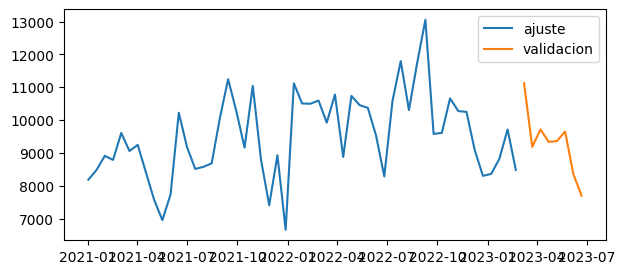

In [482]:
df_ajuste = df.loc[ : fin_ajuste]
df_validacion = df.loc[fin_ajuste : ]
plt.figure(figsize=(7,3))
plt.plot(df_ajuste,label='ajuste')
plt.plot(df_validacion, label='validacion')
plt.legend()
plt.show()

In [483]:
print("TEST DE ESTACIONARIEDAD PARA LA SERIE ORIGINAL")
print("----------------------------------------------")
adfuller_result = adfuller(df)
kpss_result = kpss(df)
print(f"Estadistico ADF: {adfuller_result[0]}, p-value: {adfuller_result[1]}")
print(f"Estadistico KPSS: {kpss_result[0]}, p-value: {kpss_result[1]}")

TEST DE ESTACIONARIEDAD PARA LA SERIE ORIGINAL
----------------------------------------------
Estadistico ADF: -4.951567266713279, p-value: 2.7649892990457424e-05
Estadistico KPSS: 0.34825820034951954, p-value: 0.09945767226313812


Text(0.5, 1.0, 'Autocorrelacion de la serie original')

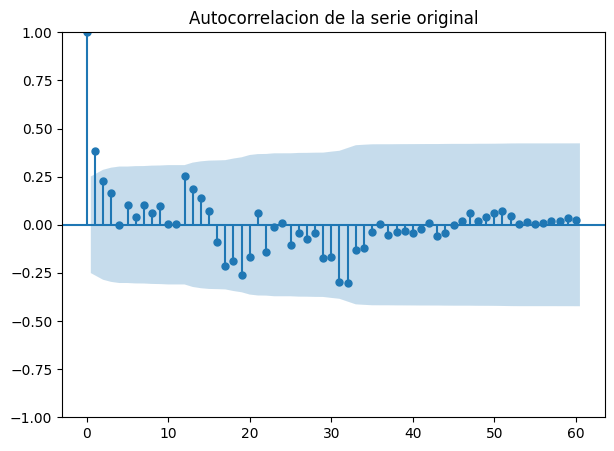

In [484]:
# Grafico de autocorrelacion
fig, ax = plt.subplots(figsize=(7, 5), sharex=True)
plot_acf(df, ax=ax, lags=60)
ax.set_title("Autocorrelacion de la serie original")

Text(0.5, 1.0, 'Autocorrelacion parcial de la serie original')

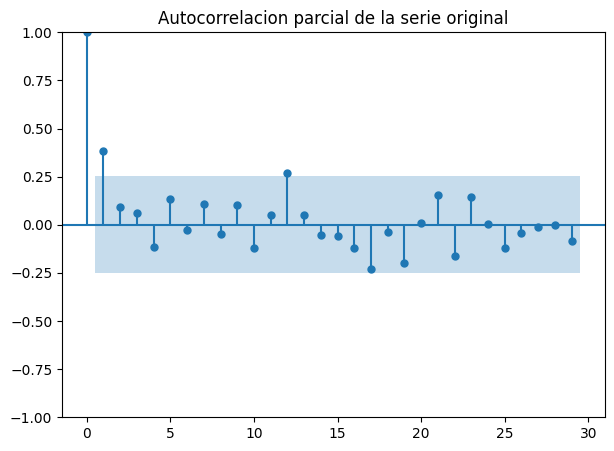

In [485]:
# Grafico de autocorrelacion parcial
fig, ax = plt.subplots(figsize=(7, 5), sharex=True)
plot_pacf(df, ax=ax, lags=29)
ax.set_title("Autocorrelacion parcial de la serie original")

d = 0
p = 1
q = 1

In [486]:
#Modelo ARIMAX
modelo = SARIMAX(endog = df_ajuste, order = (1,0,1))
modelo_res = modelo.fit(disp = 0)
modelo_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    NUM   No. Observations:                   53
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -453.641
Date:                Mon, 09 Oct 2023   AIC                            913.283
Time:                        16:47:39   BIC                            919.194
Sample:                    01-02-2021   HQIC                           915.556
                         - 02-21-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9990      0.005    191.365      0.000       0.989       1.009
ma.L1         -0.6721      0.089     -7.531      0.000      -0.847      -0.497
sigma2      1.461e+06   7.74e-09   1.89e+14      0.000    1.46e+06    1.46e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.05   Jarque-Bera (JB):                 0.48
Prob(Q):                              0.30   Prob(JB):                         0.79
Heteroskedasticity (H):               1.41   Skew:                             0.09
Prob(H) (two-sided):                  0.47   Kurtosis:                         2.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.52e+30. Standard errors may be unstable.
"""

In [487]:
predicciones_statsmodels = modelo_res.get_forecast(steps = len(df_validacion)).predicted_mean
predicciones_statsmodels.name = 'predicciones_statsmodels'
predicciones_statsmodels

2023-03-08    8956.519496
2023-03-23    8947.489191
2023-04-07    8938.467992
2023-04-22    8929.455888
2023-05-07    8920.452870
2023-05-22    8911.458930
2023-06-06    8902.474057
2023-06-21    8893.498244
Freq: 15D, Name: predicciones_statsmodels, dtype: float64

### Evaluación modelo ARIMAX

[]

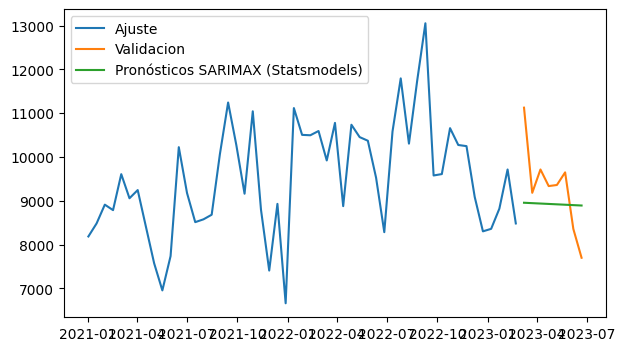

In [488]:
plt.figure(figsize = (7,4))
plt.plot(df_ajuste, label = 'Ajuste')
plt.plot(df_validacion, label = 'Validacion')
plt.plot(predicciones_statsmodels, label = 'Pronósticos SARIMAX (Statsmodels)')
plt.legend()
plt.plot()

In [489]:
mean_absolute_percentage_error(df_validacion, predicciones_statsmodels)

0.08600941139321215

Como se puede observar, con un MAPE(Mean Absolute Percentage Error) de 0.086, el modelo ARIMA (1,0,1) resulta ser muy apropiado para realizar los pronósticos necesarios y se determina como nuestro MVP. 